In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import seaborn as sns
import os
import time
from tqdm import tqdm as progress
from scipy.interpolate import interp1d
from scipy import stats
from visual_behavior.visualization.extended_trials.daily import make_lick_raster_plot
from visual_behavior.change_detection.trials import summarize
from visual_behavior.translator.core import annotate

from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

import scikit_posthocs

from pprint import pprint

import xarray as xr
import pymssql
import yaml

from multiprocessing import Pool

from sklearn.neighbors import KernelDensity

from statsmodels.stats.anova import AnovaRM

from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe
from visual_behavior.change_detection.trials import session_metrics
from visual_behavior import metrics

import visual_behavior.plotting as vbp
import visual_behavior.utilities as vbu
from visual_behavior import database as db

from IPython.core.display import Image, display

pd.set_option('display.max_columns', 500)

import utilities
import utilities as ut
import standard_plots as sp


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from src.utils.data import GenotypeLookup
from src.utils.viz import colors
genotype_lookup = GenotypeLookup()

datapath = /allen/programs/braintv/workgroups/neuralcoding/Behavior/Data/visual_behavior_development/BehaviorManuscriptData


In [2]:
from importlib import reload

In [3]:
%matplotlib notebook


## config and constants

In [4]:
mpl.rcParams.update({'font.family': ['Arial',]})

binsize = 10 # binsize for epoch level summaries

datapath = '//allen/programs/braintv/workgroups/neuralcoding/Behavior/Data/visual_behavior_development/BehaviorManuscriptData'

## functions

In [5]:
def recalculate_response_latency(row):
    if not pd.isnull(row['change_time']) and len(row['lick_times']) > 0:
        lt = np.round(np.array(row['lick_times']),3)
        post_change_licks = lt[lt>=row['change_time']]
        if len(post_change_licks) > 0:
            return post_change_licks[0] - row['change_time']
        else:
            return None
    else:
        return None

def load_trials(from_cache=True):
    if from_cache:
        data_savedir = '/allen/programs/braintv/workgroups/neuralcoding/Behavior/Data/visual_behavior_development/BehaviorManuscriptData'
        trials = pd.read_pickle(os.path.join(data_savedir, 'pilot_data_trials.2020.01.16.pkl'))
        summary = pd.read_hdf(os.path.join(data_savedir, 'pilot_data_session_summaries.2020.01.16.h5'),key='data')
    else:
        trials = pd.read_pickle('{}/data/01_standardized_training_trials.pkl'.format(datapath))
        trials = utilities.recalculate_responses(trials)
        trials['response_latency'] = trials[['change_time','lick_times']].apply(recalculate_response_latency,axis=1)

        ### image names are mixed across sets. Standardize by keeping only the three digit integer
        def relabel_image(image_name):
            if not pd.isnull(image_name):
                return "".join([char for char in image_name if char.isdigit()])
            else:
                return np.nan

        trials['initial_image_name'] = trials['initial_image_name'].map(lambda x:relabel_image(x))
        trials['change_image_name'] = trials['change_image_name'].map(lambda x:relabel_image(x))

        summary = pd.read_csv('{}/data/01_standardized_training_summary.csv'.format(datapath),index_col=0)

        master_session_summary = pd.read_csv(os.path.join(datapath,'master_session_summary.csv'))

        #merge in behavior session UUID
        master_session_summary['date'] = master_session_summary['session_datetime'].map(lambda x:pd.to_datetime(x).strftime("%y-%m-%d"))

        summary['date'] = summary['session_datetime'].map(lambda x:pd.to_datetime(x).strftime("%y-%m-%d"))

        master_session_summary['mouse_date'] = master_session_summary['mouse_id'] + master_session_summary['date']

        summary['mouse_date'] = summary['mouse_id'] + summary['date']

        summary = summary.merge(master_session_summary[['behavior_session_uuid','mouse_date']],left_on='mouse_date',right_on='mouse_date')

        trials = trials.merge(summary[['behavior_session_uuid','expert_session']],left_on='behavior_session_uuid',right_on='behavior_session_uuid')

    return trials, summary

In [15]:
datapath = '//allen/programs/braintv/workgroups/neuralcoding/Behavior/Data/visual_behavior_development/BehaviorManuscriptData'
data_save_folder = '/home/dougo/dropbox/BrainTV-BehaviorDevelopment/Manuscripts/2019 - DoC_Behavioral_Characterization'
toplevel_figure_folder = '/home/dougo/dropbox/BrainTV-BehaviorDevelopment/Manuscripts/2019 - DoC_Behavioral_Characterization/Figures/Figures'

figure3_folder = 'Figure 3 - Task engagement over session/Figure 3 components_v2'
figure3_savepath = os.path.join(toplevel_figure_folder,figure3_folder)

figure4_folder = 'Figure 4 - Performance in engagement states/Figure 4 components_v2'
figure4_savepath = os.path.join(toplevel_figure_folder,figure4_folder)

figure5_folder = 'Figure 5 - Psychophysics in Motivated State/Figure 5 components_v2'
figure5_savepath = os.path.join(toplevel_figure_folder,figure5_folder)

supp3_folder = 'Figure_S3-crtierion_v_abort_fraction'
supp3_savepath = os.path.join(toplevel_figure_folder,supp3_folder)

save_figures = True

## load data

In [16]:
trials_from_cache = True
if trials_from_cache:
    trials,summary = load_trials(from_cache=True)
else:
    trials,summary = load_trials(from_cache=False)
expert_sessions = summary.query('expert_session == True')

In [17]:
mice_in_summary = len(summary.mouse_id.unique())
expert_mice = len(expert_sessions.mouse_id.unique())
print('of {} mice, {} had at least 1 expert session'.format(mice_in_summary,expert_mice))

of 60 mice, 56 had at least 1 expert session


In [21]:
np.sort(trials.columns)

array(['_id', 'auto_rewarded', 'behavior_session_id',
       'behavior_session_uuid', 'blank_duration_range',
       'blank_screen_timeout', 'change_contrast', 'change_frame',
       'change_image_category', 'change_image_name', 'change_ori',
       'change_time', 'change_time_delay_adjusted', 'cohort', 'color',
       'computer_name', 'criterion_negative_corrected',
       'criterion_negative_raw', 'cumulative_reward_number',
       'cumulative_volume', 'date', 'day', 'dayofweek', 'delta_ori',
       'distribution_mean', 'endframe', 'endtime', 'epoch',
       'expert_session', 'genotype', 'hour', 'index', 'initial_contrast',
       'initial_image_category', 'initial_image_name', 'initial_ori',
       'lick_frames', 'lick_times', 'lims_id', 'month', 'mouse_id',
       'number_of_rewards', 'optogenetics', 'prechange_minimum',
       'response', 'response_latency', 'response_time', 'response_type',
       'response_window', 'reward_frames', 'reward_lick_count',
       'reward_lick_latenc

In [29]:
def count_licks(row):
    return len(row['lick_times'])
trials['number_of_licks'] = trials.apply(count_licks,axis=1)

In [85]:
mouse_id = 'M324022'
mouse_trials = trials.query('mouse_id == @mouse_id').sort_values(by=['startdatetime','starttime'])
trials_sample = mouse_trials.query('number_of_licks > 0 and trial_type == "go" and stage == "static_full_field_gratings"').copy().reset_index()

In [86]:
def get_first_lick_time(row):
    return row['lick_times'][0] - row['change_time']
trials_sample['first_lick_time'] = trials_sample.apply(get_first_lick_time,axis=1)

<IPython.core.display.Javascript object>


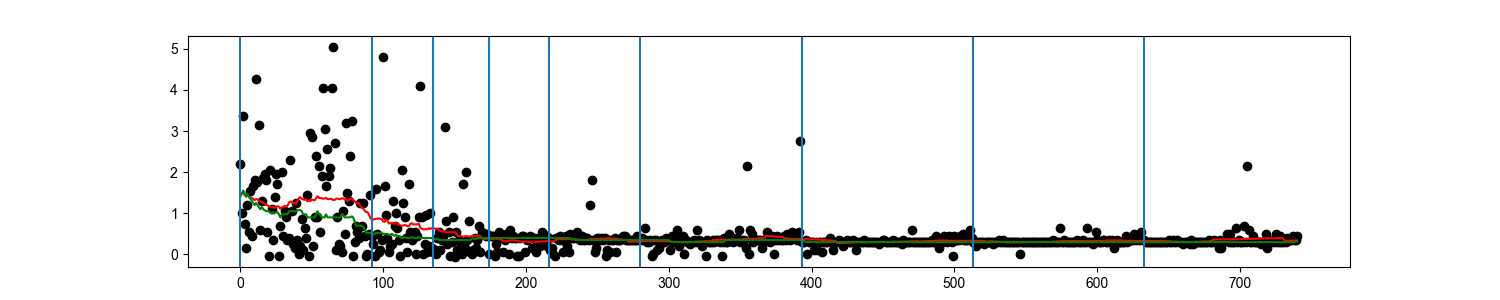

In [88]:
fig,ax=plt.subplots(figsize=(15,3))
ax.plot(trials_sample['first_lick_time'],'ok')
ax.plot(trials_sample.rolling(window=50,min_periods=0,center=True)['first_lick_time'].mean(),color='red')
ax.plot(trials_sample.rolling(window=50,min_periods=0,center=True)['first_lick_time'].median(),color='green')

trials_sample['new_session'] = trials_sample['behavior_session_uuid'] != trials_sample['behavior_session_uuid'].shift()
for idx,first_trial in trials_sample.query('new_session == True').iterrows():
    ax.axvline(idx)
#     ax.text(idx,5,first_trial['stage'])